In [1]:
%matplotlib inline
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Inspect database

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23',)

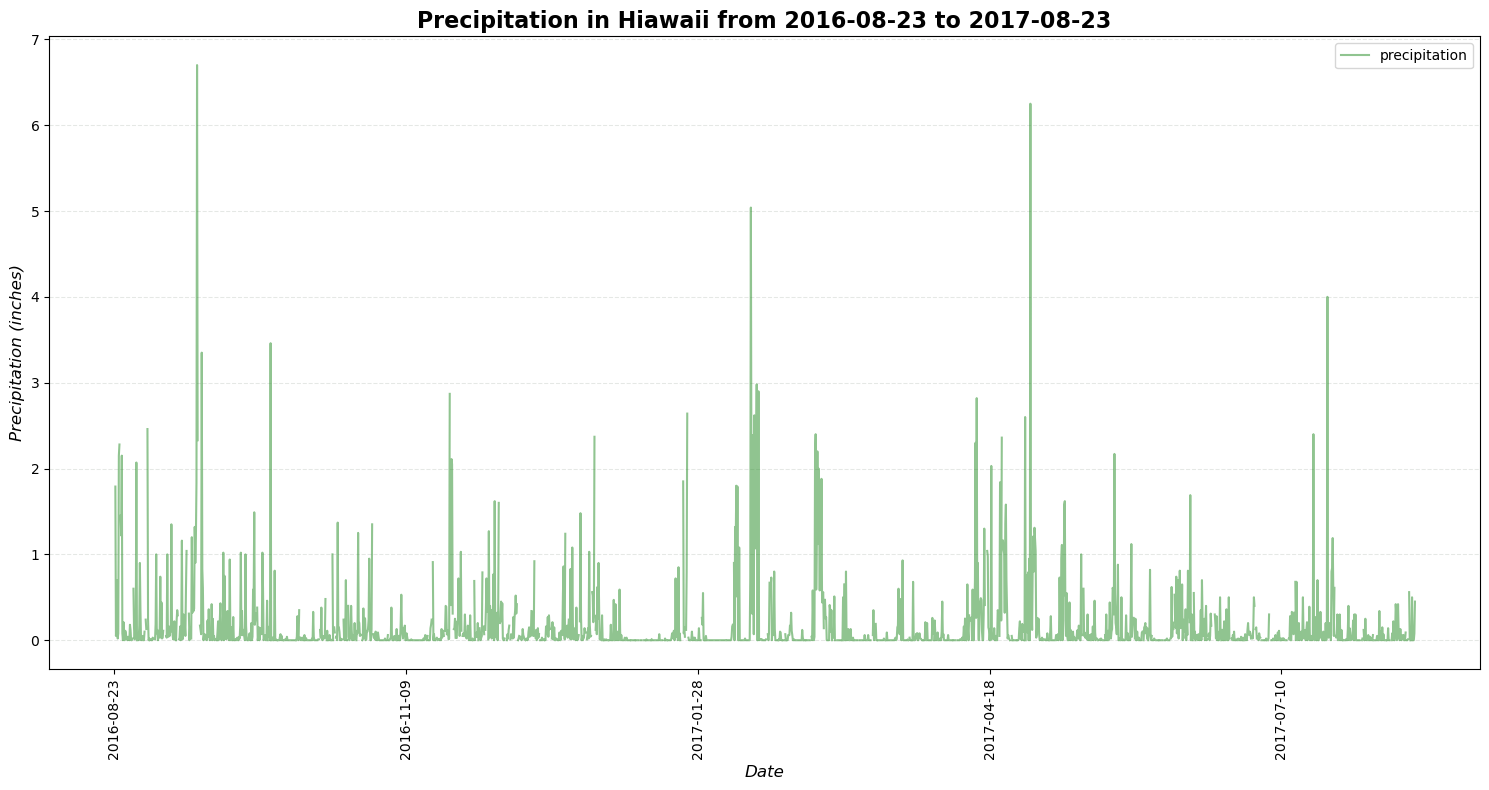

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.


# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df.sort_values(by=['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='date', y='precipitation', figsize=(15,8), c='forestgreen', alpha=0.5)

plt.title(f"Precipitation in Hiawaii from 2016-08-23 to 2017-08-23", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontstyle="italic")
plt.ylabel("Precipitation (inches)", fontsize=12, fontstyle="italic")
plt.grid(color="#022200", axis="y", linestyle="--", alpha=0.1)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("images/precipitation.png")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.id).desc()).\
            all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active_stations[0][0]

most_active_temp_agg = session.query(Measurement.station,
                                     func.min(Measurement.tobs), 
                                     func.max(Measurement.tobs), 
                                     func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_id).\
        all()

most_active_temp_agg_df = pd.DataFrame(most_active_temp_agg, columns=['station', 'min_temp', 'max_temp', 'avg_temp'])
most_active_temp_agg_df.head()


,station,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


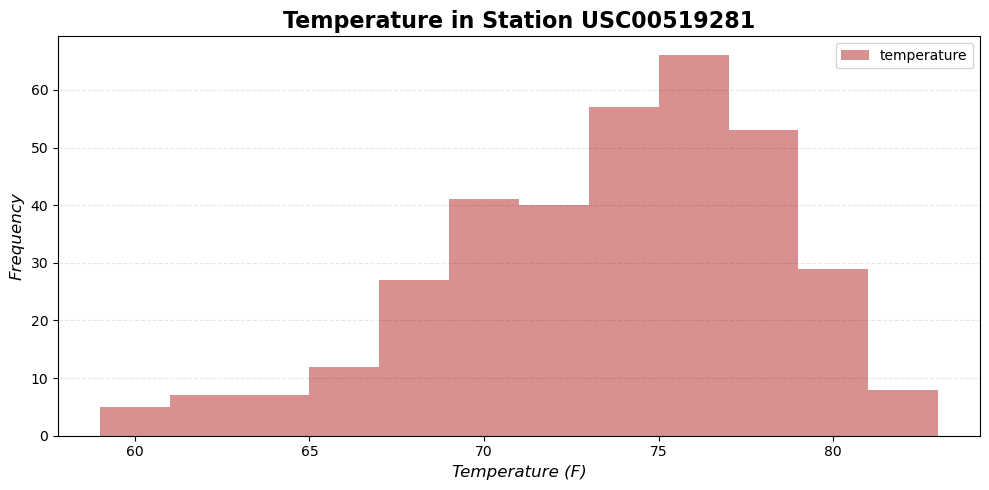

In [16]:

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == most_active_id).all()

# Save the query results as a Pandas DataFrame
most_active_temp_df = pd.DataFrame(most_active_temp, columns=['date', 'temperature'])

# Use Pandas Plotting with Matplotlib to plot the data
most_active_temp_df.plot.hist(bins=12, alpha=0.5, figsize=(10,5), color='firebrick')

plt.title(f"Temperature in Station {most_active_id}", fontsize=16, fontweight="bold")
plt.xlabel("Temperature (F)", fontsize=12, fontstyle="italic")
plt.ylabel("Frequency", fontsize=12, fontstyle="italic")
plt.grid(color="#022200", axis="y", linestyle="--", alpha=0.1)

plt.tight_layout()
plt.savefig("images/station-histogram.png")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()
